In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
import pandas as pd
import seaborn as sns
import zipfile
import io
from sklearn.preprocessing import StandardScaler
import scipy
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

### MPG DATA ###

In [2]:
#   load mpg data
mpg_path = '/Users/elvissmith/Desktop/COGS_118A/FInal project/auto+mpg.zip'
with zipfile.ZipFile(mpg_path, 'r') as zip_ref:
    with zip_ref.open('auto-mpg.data') as file:
        mpg = pd.read_csv(file, sep='\s+')
columns = [
    'mpg','cylinders', 'displacement',
    'horsepower','weight', 'acceleration',
    'model_year','origin', 'car_name'
    ]
mpg.columns = columns

#   drop missing values
mpg.replace("?", np.nan, inplace=True)

#   split dataset into two classes (high mpg vs low mpg) with the threshold being the median mpg of all cars
mpg_threshold = mpg['mpg'].median() # threshold
mpg['Y'] = mpg['mpg'].apply(lambda x: 1 if x >= mpg_threshold else -1)

#   drop Y and car_names columns before normalizing
yM = mpg['Y']
cM = mpg['car_name']
mpg = mpg.drop(columns = ["Y",'car_name'])

#  normalize data to avoid disproportionate influence 
scaler = StandardScaler()
mpg_scaled = scaler.fit_transform(mpg)
mpg = pd.DataFrame(mpg_scaled, columns = mpg.columns)

#   add car names and Y back to mpg data (car_names will only be used at the end as labels for points)
mpg["Y"] = yM
mpg['car_name'] = cM

In [3]:
#   drop car_names since its
mpg.dropna(inplace = True)
XM = mpg.drop(columns = ['car_name', 'Y','mpg'])
YM = mpg['Y']

### ABALONE DATA ###

In [4]:
#   load abalone data
abalone_path = '/Users/elvissmith/Desktop/COGS_118A/FInal project/abalone.zip'
with zipfile.ZipFile(abalone_path, 'r') as zip_ref:
    with zip_ref.open('abalone.data') as file:
        abalone = pd.read_csv(file)
columns = [
    "Sex", "Length", "Diameter", "Height", 
    "WholeWeight", "ShuckedWeight", 
    "VisceraWeight", "ShellWeight", "Rings"
]
abalone.columns = columns

#   slip the dataset into two classes (young vs old) with the threshold for age being the median
abalone_threshold = abalone['Rings'].median() # defines classifier threshold
abalone['Y'] = abalone['Rings'].apply(lambda x: 1 if x >= abalone_threshold else -1)
abalone = abalone.drop(columns = ['Sex']) # drop catagorical data for simplicity

#   take Y and Rings column out so its not normalized
yA = abalone['Y']
rA = abalone['Rings']
abalone = abalone.drop(columns = ['Y','Rings'])

#   noramlize the numercal values so that it can't be disproportionately influenced
scaler = StandardScaler()
abalone_scaled = scaler.fit_transform(abalone)
abalone = pd.DataFrame(abalone_scaled, columns=abalone.columns)

#   add Y Rings column back to abalone (Rings will be used as labels at the end)
abalone['Y'] = yA
abalone['Rings'] = rA


In [5]:
XA = abalone.drop(columns = ['Rings','Y']) # values without classifier
YA = abalone["Y"]


### IRIS DATA ###

In [6]:
#   load in iris data 
iris = datasets.load_iris()
XI = iris.data
XI.view()

#   each instance is an individual plant
#   150 entries are partitioned into 3 different types of iris plant (50 each)
#   
#   we will divide the 3 types into two different classes:
#       Y = -1: Setosa and Versicolor 
#       Y = 1: Virginica
YI = (iris.target > 1.5).reshape(-1,1).astype(float)
YI[YI==0] = -1 # for cases of zero values

In [7]:
# combine X and Y values onto same array
XI_YI = np.hstack((XI,YI))
np.random.seed(1)
np.random.shuffle(XI_YI) # shuffles the data point so the plant types aren't seprated

print(XI.shape)
print(YI.shape)
print(XI_YI.shape)

(150, 4)
(150, 1)
(150, 5)


In [8]:
XI_shuffled = XI_YI[:,:4] # shuffled just the first 4 columns of X_Y
YI_shuffled = XI_YI[:,4] 

### Random Forest Parameters ###

In [9]:
#   Random Foresrt parameters
param_grid = {
    'n_estimators': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 125, 150, 175, 200],
    'max_depth': [3, 5, 7, 10, 15],
    'max_features': ['sqrt', 'log2']
}

def run_grid_search(X_train, Y_train, param_grid, cv=5, scoring='accuracy'):
    rf = RandomForestClassifier(random_state=1)  # Initialize Random Forest model
    
    # Initialize GridSearchCV
    rf_grid = GridSearchCV(
        estimator=rf,
        param_grid=param_grid,
        cv=cv,
        scoring=scoring,
    )
    rf_grid.fit(X_train, Y_train)
    return rf_grid.best_params_, rf_grid, rf


### Optimal Hyper Parameters for Iris Data ###

In [10]:
#   (80/20)
XI_train_80, XI_test_20, YI_train_80, YI_test_20 = train_test_split(XI_shuffled, YI_shuffled, test_size=0.2, random_state=1)
#   (20/80)
XI_train_20, XI_test_80, YI_train_20, YI_test_80 = train_test_split(XI_shuffled, YI_shuffled, test_size=0.8, random_state=1)
#   (50/50)
XI_train_50, XI_test_50, YI_train_50, YI_test_50 = train_test_split(XI_shuffled, YI_shuffled, test_size=0.5, random_state=1)
print(XI_shuffled.shape)

(150, 4)


In [11]:
#   optimal parameters and test accuracy (80/20)
optimal_params_80_20, rf_grid_80_20, rf = run_grid_search(XI_train_80, YI_train_80, param_grid);
test_accuracy = rf_grid_80_20.score(XI_test_20, YI_test_20)
train_predictions = rf_grid_80_20.predict(XI_train_80)
train_accuracy_manual = accuracy_score(YI_train_80, train_predictions)
cv_scores = cross_val_score(rf, XI_train_80, YI_train_80, cv=5)

print('Optimal Parameters (80/20):', optimal_params_80_20)
print(f'Test Accuracy (80/20): {test_accuracy:.3f}')
print(f"Train Accuracy (80/20): {train_accuracy_manual}")
print(f"Cross Validation Scores: {cv_scores}")

/Users/elvissmith/Library/Python/3.9/lib/python/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Optimal Parameters (80/20): {'max_depth': 3, 'max_features': 'sqrt', 'n_estimators': 20}
Test Accuracy (80/20): 0.933
Train Accuracy (80/20): 0.9916666666666667
Cross Validation Scores: [0.91666667 0.95833333 1.         0.95833333 0.91666667]


In [ ]:
# optimal parameters and test accuracy (20/80)
optimal_params_20_80, rf_grid_20_80, rf = run_grid_search(XI_train_20, YI_train_20, param_grid);
test_accuracy = rf_grid_20_80.score(XI_test_80, YI_test_80)
train_predictions = rf_grid_20_80.predict(XI_train_20)
train_accuracy_manual = accuracy_score(YI_train_20, train_predictions)
cv_scores = cross_val_score(rf, XI_train_20, YI_train_20, cv=5)

print('Optimal Parameters (20/80):', optimal_params_20_80)
print(f'Test Accuracy (20/80): {test_accuracy:.3f}')
print(f"Train Accuracy (20/80): {train_accuracy_manual}")
print(f"Cross Validation Scores: {cv_scores}")

/Users/elvissmith/Library/Python/3.9/lib/python/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Optimal Parameters (20/80): {'max_depth': 3, 'max_features': 'sqrt', 'n_estimators': 20}
Test Accuracy (20/80): 0.950
Train Accuracy (80/20): 1.0
Cross Validation Scores: [1.         1.         0.83333333 1.         0.83333333]


In [13]:
#   optimal parameters and test accuracy (50/50)
optimal_params_50_50, rf_grid_50_50, rf = run_grid_search(XI_train_50, YI_train_50, param_grid);
test_accuracy = rf_grid_50_50.score(XI_test_50, YI_test_50)
train_predictions = rf_grid_50_50.predict(XI_train_50)
train_accuracy = accuracy_score(YI_train_50, train_predictions)
cv_scores = cross_val_score(rf, XI_train_50, YI_train_50, cv=5)

print('Optimal Parameters (50/50):', optimal_params_50_50)
print(f'Test Accuracy (50/50): {test_accuracy:.3f}')
print(f'Train Accuracy (50/50): {train_accuracy:.3f}')
print(f"Cross Validation Scores: {cv_scores}")

/Users/elvissmith/Library/Python/3.9/lib/python/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Optimal Parameters (50/50): {'max_depth': 3, 'max_features': 'sqrt', 'n_estimators': 40}
Test Accuracy (50/50): 0.947
Train Accuracy (50/50): 1.000
Cross Validation Scores: [1.         0.93333333 0.93333333 0.93333333 1.        ]


### Heat Maps for Iris Data

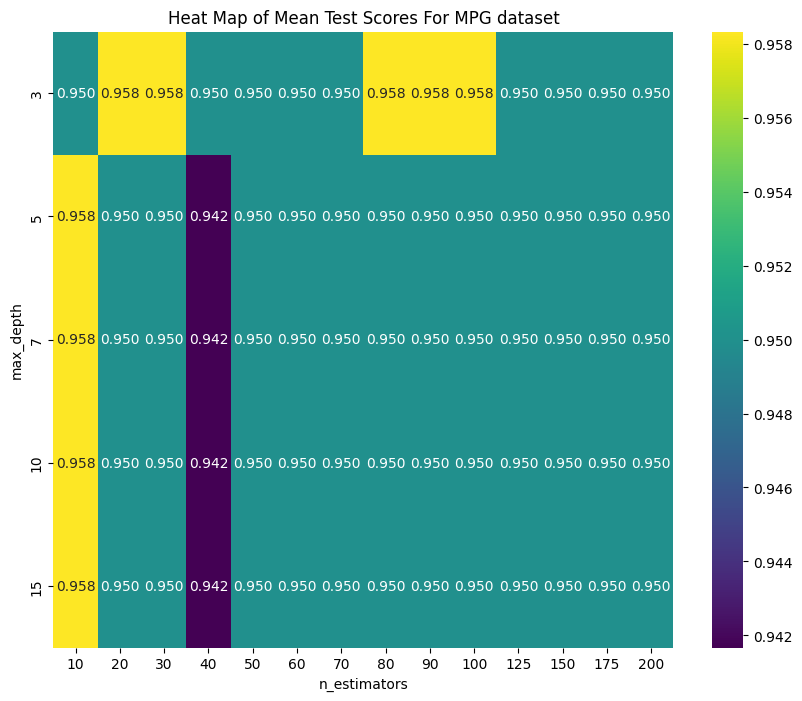

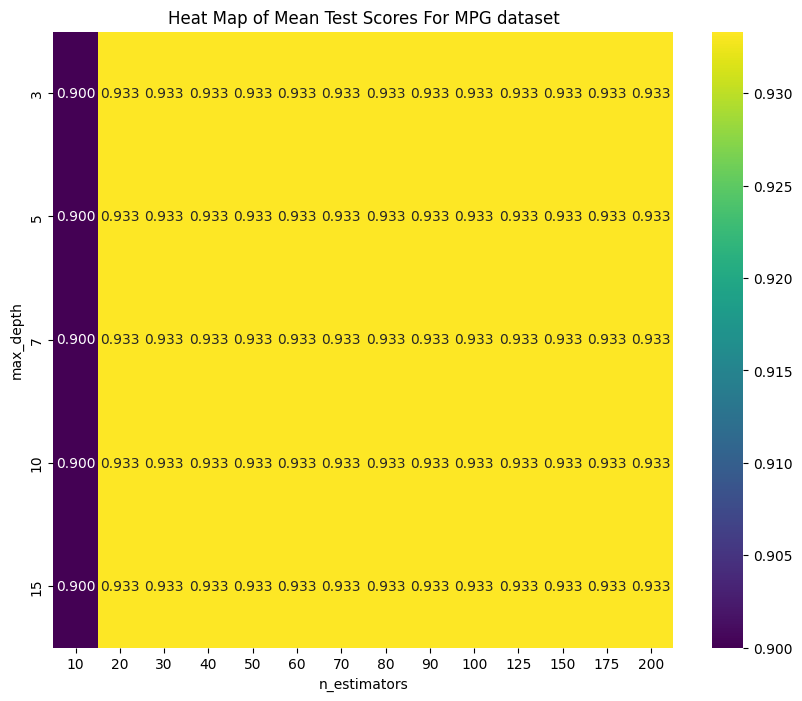

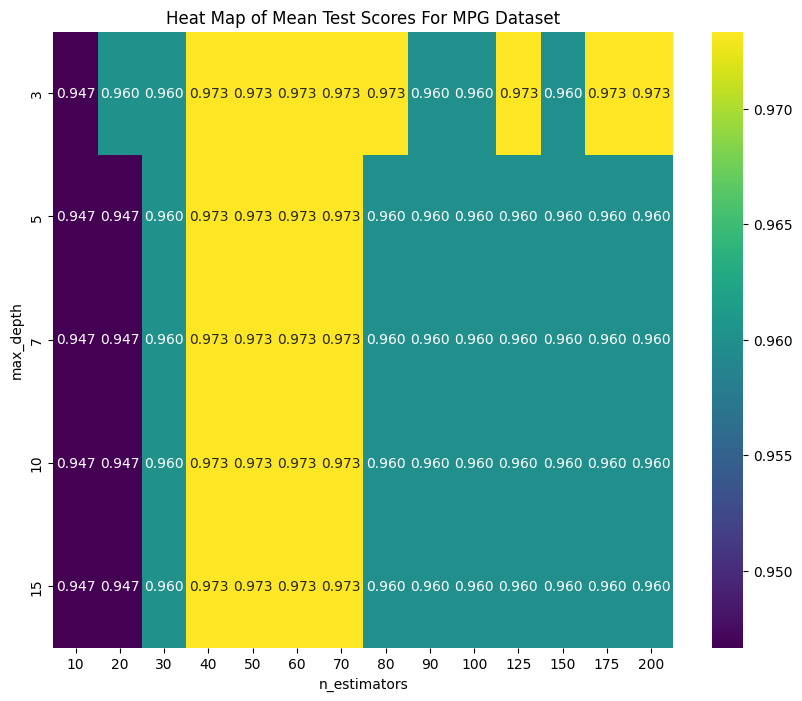

In [15]:
results_80_20 = rf_grid_80_20.cv_results_
# data of interest
results_df_80_20 = pd.DataFrame({ 
    'n_estimators': results_80_20['param_n_estimators'].data,
    'max_depth': results_80_20['param_max_depth'].data,
    'max_features': results_80_20['param_max_features'].data,
    'mean_test_score': results_80_20['mean_test_score'],})
heatmap_data = results_df_80_20.pivot_table(
    values='mean_test_score',
    index='max_depth',
    columns='n_estimators')
#  Plot
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, annot=True, fmt=".3f", cmap="viridis")
plt.title('Heat Map of Mean Test Scores For MPG dataset')
plt.xlabel('n_estimators')
plt.ylabel('max_depth')
plt.show()

results_20_80 = rf_grid_20_80.cv_results_
# data of interest
results_df_20_80 = pd.DataFrame({
    'n_estimators': results_20_80['param_n_estimators'].data,
    'max_depth': results_20_80['param_max_depth'].data,
    'max_features': results_20_80['param_max_features'].data,
    'mean_test_score': results_20_80['mean_test_score'],})
heatmap_data = results_df_20_80.pivot_table(
    values='mean_test_score',
    index='max_depth',
    columns='n_estimators')
#   Plot
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, annot=True, fmt=".3f", cmap="viridis")
plt.title('Heat Map of Mean Test Scores For MPG dataset')
plt.xlabel('n_estimators')
plt.ylabel('max_depth')
plt.show()

results_50_50 = rf_grid_50_50.cv_results_
# data of interest
results_df_50_50 = pd.DataFrame({
    'n_estimators': results_50_50['param_n_estimators'].data,
    'max_depth': results_50_50['param_max_depth'].data,
    'max_features': results_50_50['param_max_features'].data,
    'mean_test_score': results_50_50['mean_test_score'],})
heatmap_data = results_df_50_50.pivot_table(
    values='mean_test_score',
    index='max_depth',
    columns='n_estimators')
#   Plot
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, annot=True, fmt=".3f", cmap="viridis")
plt.title('Heat Map of Mean Test Scores For MPG Dataset')
plt.xlabel('n_estimators')
plt.ylabel('max_depth')
plt.show()

### Accuracy Curves for each Iris Partition

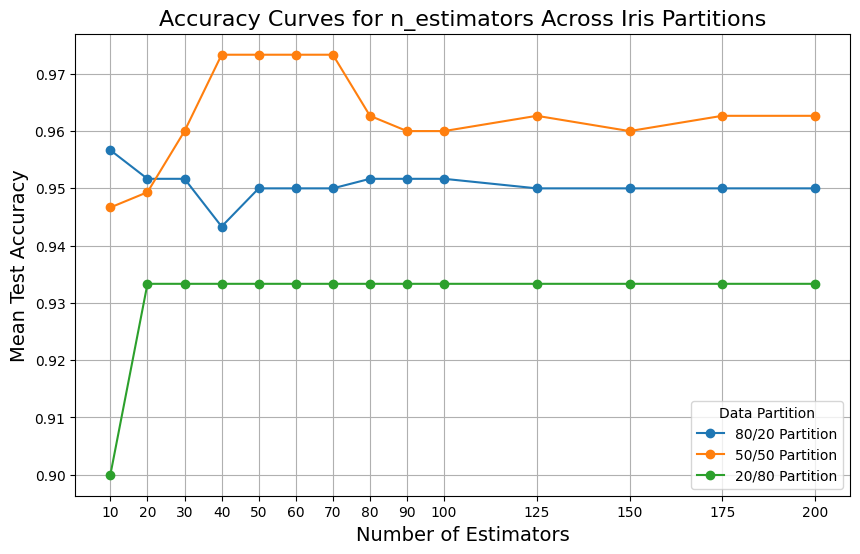

In [16]:
partitions = {
    '80/20': (rf_grid_80_20, XI_test_20, YI_test_20),
    '50/50': (rf_grid_50_50, XI_test_50, YI_test_50),
    '20/80': (rf_grid_20_80, XI_test_80, YI_test_80)}
plt.figure(figsize=(10, 6))
# Loop through each partition
for partition_name, (rf_grid, X_test, Y_test) in partitions.items():
    results_df = pd.DataFrame(rf_grid.cv_results_)
    accuracy_curve_data = results_df.groupby('param_n_estimators')['mean_test_score'].mean()
    # Plot
    plt.plot(
        accuracy_curve_data.index,
        accuracy_curve_data.values,
        marker='o',
        linestyle='-',
        label=f'{partition_name} Partition')
plt.title('Accuracy Curves for n_estimators Across Iris Partitions', fontsize=16)
plt.xlabel('Number of Estimators', fontsize=14)
plt.ylabel('Mean Test Accuracy', fontsize=14)
plt.grid(True)
plt.legend(title='Data Partition')
plt.xticks(accuracy_curve_data.index)
plt.show()

### Optimal Hyper Parameters for Abalone Data

In [17]:
#   (80/20)
XA_train_80, XA_test_20, YA_train_80, YA_test_20 = train_test_split(XA, YA, test_size=0.2, random_state=1)
#   (20/80)
XA_train_20, XA_test_80, YA_train_20, YA_test_80 = train_test_split(XA, YA, test_size=0.8, random_state=1)
#   (50/50)
XA_train_50, XA_test_50, YA_train_50, YA_test_50 = train_test_split(XA, YA, test_size=0.5, random_state=1)

In [ ]:
#   optimal parameters and test accuracy (80/20)
optimal_params_80_20, rf_grid_80_20, rf = run_grid_search(XA_train_80, YA_train_80, param_grid);
test_accuracy = rf_grid_80_20.score(XA_test_20, YA_test_20)
train_predictions = rf_grid_80_20.predict(XA_train_80)
train_accuracy = accuracy_score(YA_train_80, train_predictions)
cv_scores = cross_val_score(rf, XA_train_80, YA_train_80, cv=5)

print('Optimal Parameters (80/20):', optimal_params_80_20)
print(f'Test Accuracy (80/20): {test_accuracy:.3f}')
print(f"Train Accuracy (80/20): {train_accuracy}")
print(f"Cross Validation Scores: {cv_scores}")

/Users/elvissmith/Library/Python/3.9/lib/python/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Optimal Parameters (80/20): {'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 20}
Test Accuracy (80/20): 0.828
Train Accuracy (80/20): 0.9344311377245509
Cross Validation Scores: [0.85479042 0.83832335 0.84431138 0.82784431 0.82185629]


In [25]:
#   optimal parameters and test accuracy (20/80)
optimal_params_20_80, rf_grid_20_80, rf = run_grid_search(XA_train_20, YA_train_20, param_grid);
test_accuracy = rf_grid_20_80.score(XA_test_80, YA_test_80)
train_predictions = rf_grid_20_80.predict(XA_train_20)
train_accuracy = accuracy_score(YA_train_20, train_predictions)
cv_scores = cross_val_score(rf, XA_train_20, YA_train_20, cv=5)

print('Optimal Parameters (20/80):', optimal_params_20_80)
print(f'Test Accuracy (20/80): {test_accuracy:.3f}')
print(f"Train Accuracy (20/80): {train_accuracy}")
print(f"Cross Validation Scores: {cv_scores}")

/Users/elvissmith/Library/Python/3.9/lib/python/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Optimal Parameters (20/80): {'max_depth': 7, 'max_features': 'sqrt', 'n_estimators': 150}
Test Accuracy (20/80): 0.837
Train Accuracy (20/80): 0.9233532934131736
Cross Validation Scores: [0.82035928 0.83233533 0.84431138 0.82035928 0.81437126]


In [26]:
#   optimal parameters and test accuracy (50/50)
optimal_params_50_50, rf_grid_50_50, rf = run_grid_search(XA_train_50, YA_train_50, param_grid);
test_accuracy = rf_grid_50_50.score(XA_test_50, YA_test_50)
train_predictions = rf_grid_50_50.predict(XA_train_50)
train_accuracy = accuracy_score(YA_train_50, train_predictions)
cv_scores = cross_val_score(rf, XA_train_50, YA_train_50, cv=5)

print('Optimal Parameters (50/50):', optimal_params_50_50)
print(f'Test Accuracy (50/50): {test_accuracy:.3f}')
print(f'Train Accuracy (50/50): {train_accuracy:.3f}')
print(f"Cross Validation Scores: {cv_scores}")

/Users/elvissmith/Library/Python/3.9/lib/python/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Optimal Parameters (50/50): {'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 200}
Test Accuracy (50/50): 0.838
Train Accuracy (50/50): 0.955
Cross Validation Scores: [0.84688995 0.83732057 0.83971292 0.82733813 0.80815348]


### Heat Maps for each Abalone Partition

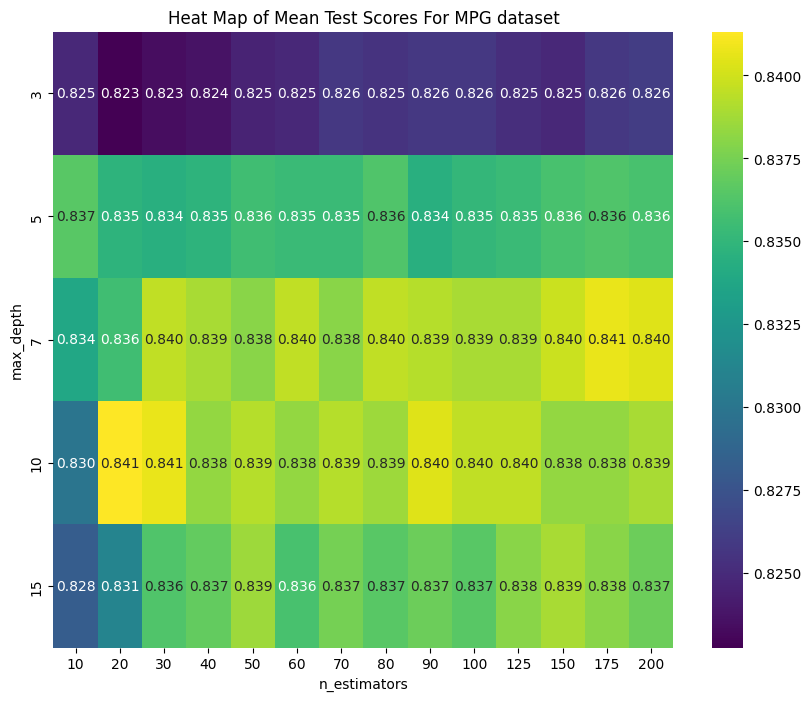

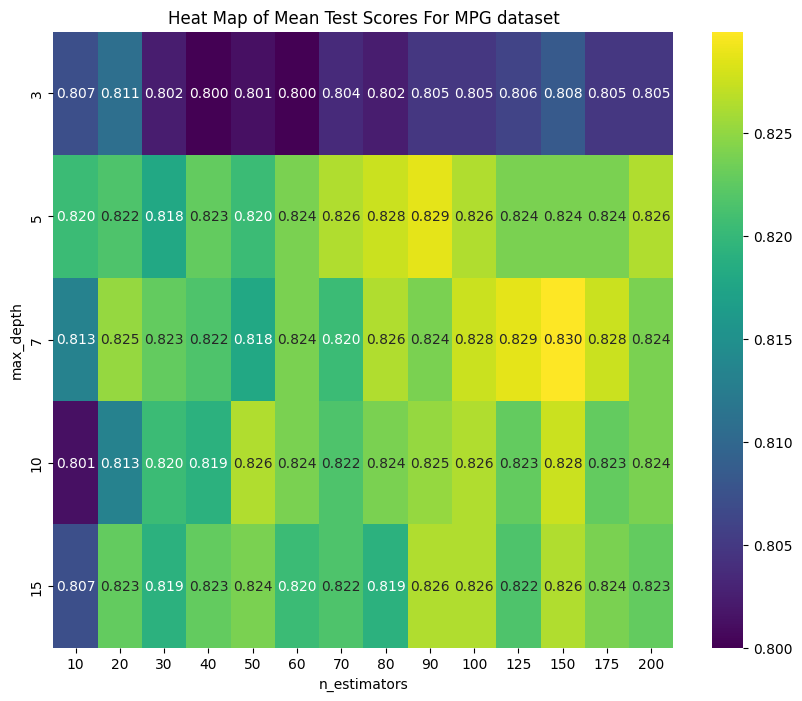

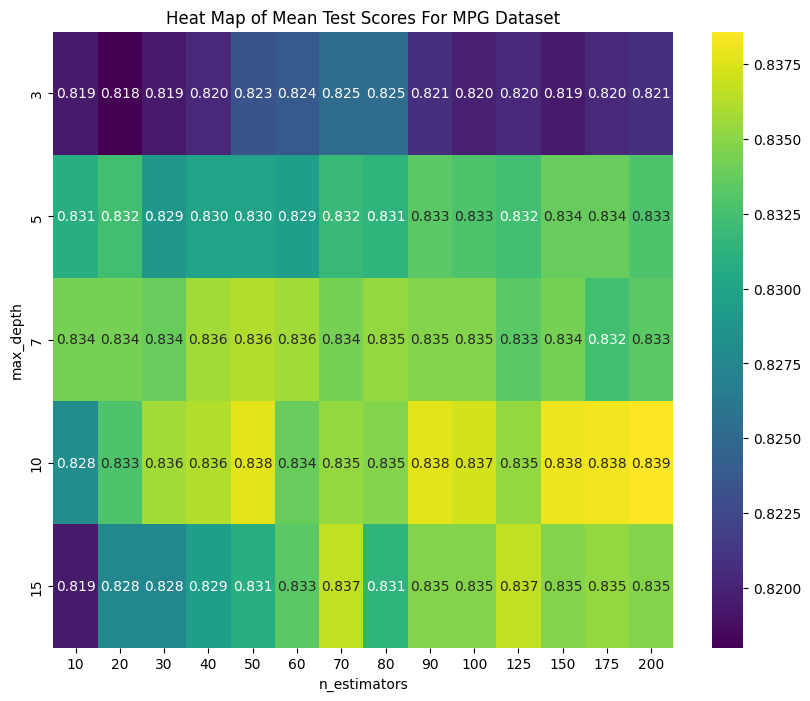

In [27]:
results_80_20 = rf_grid_80_20.cv_results_
# data of interest
results_df_80_20 = pd.DataFrame({ 
    'n_estimators': results_80_20['param_n_estimators'].data,
    'max_depth': results_80_20['param_max_depth'].data,
    'max_features': results_80_20['param_max_features'].data,
    'mean_test_score': results_80_20['mean_test_score'],})
heatmap_data = results_df_80_20.pivot_table(
    values='mean_test_score',
    index='max_depth',
    columns='n_estimators')
#  Plot
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, annot=True, fmt=".3f", cmap="viridis")
plt.title('Heat Map of Mean Test Scores For MPG dataset')
plt.xlabel('n_estimators')
plt.ylabel('max_depth')
plt.show()

results_20_80 = rf_grid_20_80.cv_results_
# data of interest
results_df_20_80 = pd.DataFrame({
    'n_estimators': results_20_80['param_n_estimators'].data,
    'max_depth': results_20_80['param_max_depth'].data,
    'max_features': results_20_80['param_max_features'].data,
    'mean_test_score': results_20_80['mean_test_score'],})
heatmap_data = results_df_20_80.pivot_table(
    values='mean_test_score',
    index='max_depth',
    columns='n_estimators')
#   Plot
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, annot=True, fmt=".3f", cmap="viridis")
plt.title('Heat Map of Mean Test Scores For MPG dataset')
plt.xlabel('n_estimators')
plt.ylabel('max_depth')
plt.show()

results_50_50 = rf_grid_50_50.cv_results_
# data of interest
results_df_50_50 = pd.DataFrame({
    'n_estimators': results_50_50['param_n_estimators'].data,
    'max_depth': results_50_50['param_max_depth'].data,
    'max_features': results_50_50['param_max_features'].data,
    'mean_test_score': results_50_50['mean_test_score'],})
heatmap_data = results_df_50_50.pivot_table(
    values='mean_test_score',
    index='max_depth',
    columns='n_estimators')
#   Plot
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, annot=True, fmt=".3f", cmap="viridis")
plt.title('Heat Map of Mean Test Scores For MPG Dataset')
plt.xlabel('n_estimators')
plt.ylabel('max_depth')
plt.show()

### Accuracy Curve for each Abalone Partition

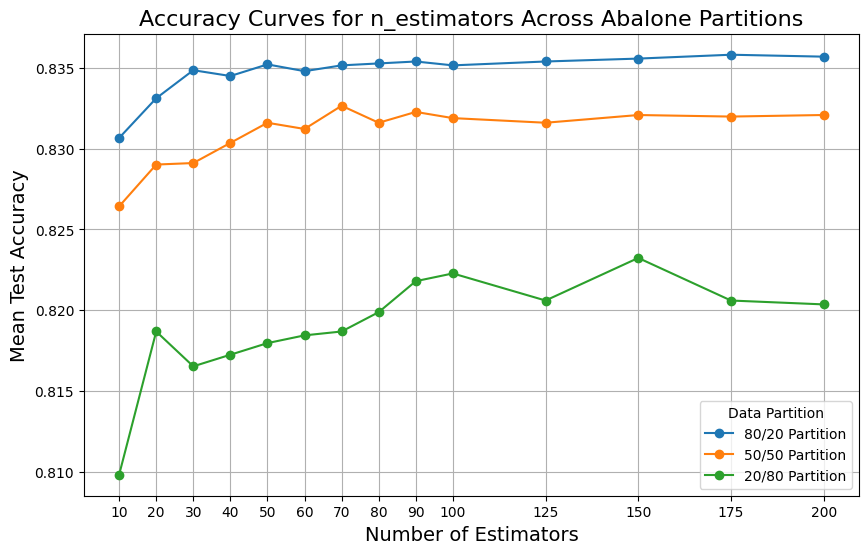

In [28]:
partitions = {
    '80/20': (rf_grid_80_20, XA_test_20, YA_test_20),
    '50/50': (rf_grid_50_50, XA_test_50, YA_test_50),
    '20/80': (rf_grid_20_80, XA_test_80, YA_test_80)}
plt.figure(figsize=(10, 6))
# Loop through each partition
for partition_name, (rf_grid, X_test, Y_test) in partitions.items():
    results_df = pd.DataFrame(rf_grid.cv_results_)
    accuracy_curve_data = results_df.groupby('param_n_estimators')['mean_test_score'].mean()
    # Plot
    plt.plot(
        accuracy_curve_data.index,
        accuracy_curve_data.values,
        marker='o',
        linestyle='-',
        label=f'{partition_name} Partition')
plt.title('Accuracy Curves for n_estimators Across Abalone Partitions', fontsize=16)
plt.xlabel('Number of Estimators', fontsize=14)
plt.ylabel('Mean Test Accuracy', fontsize=14)
plt.grid(True)
plt.legend(title='Data Partition')
plt.xticks(accuracy_curve_data.index)
plt.show()

### Optimal Hyper Parameters for MPG Data

In [29]:
#   (80/20)
XM_train_80, XM_test_20, YM_train_80, YM_test_20 = train_test_split(XM, YM, test_size=0.2, random_state=1)
#   (20/80)
XM_train_20, XM_test_80, YM_train_20, YM_test_80 = train_test_split(XM, YM, test_size=0.8, random_state=1)
#   (50/50)
XM_train_50, XM_test_50, YM_train_50, YM_test_50 = train_test_split(XM, YM, test_size=0.5, random_state=1)

In [30]:
#   optimal parameters and test accuracy (80/20)
optimal_params_80_20, rf_grid_80_20, rf = run_grid_search(XM_train_80, YM_train_80, param_grid);
test_accuracy = rf_grid_80_20.score(XM_test_20, YM_test_20)
train_predictions = rf_grid_80_20.predict(XM_train_80)
train_accuracy = accuracy_score(YM_train_80, train_predictions)
cv_scores = cross_val_score(rf, XM_train_80, YM_train_80, cv=5)

print('Optimal Parameters (80/20):', optimal_params_80_20)
print(f'Test Accuracy (80/20): {test_accuracy:.3f}')
print(f"Train Accuracy (80/20): {train_accuracy}")
print(f"Cross Validation Scores: {cv_scores}")

/Users/elvissmith/Library/Python/3.9/lib/python/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Optimal Parameters (80/20): {'max_depth': 7, 'max_features': 'sqrt', 'n_estimators': 80}
Test Accuracy (80/20): 0.937
Train Accuracy (80/20): 0.9903846153846154
Cross Validation Scores: [0.96825397 0.93650794 0.9516129  0.91935484 0.93548387]


In [31]:
#   optimal parameters and test accuracy (20/80)
optimal_params_20_80, rf_grid_20_80, rf = run_grid_search(XM_train_20, YM_train_20, param_grid);
test_accuracy = rf_grid_20_80.score(XM_test_80, YM_test_80)
train_predictions = rf_grid_20_80.predict(XM_train_20)
train_accuracy = accuracy_score(YM_train_20, train_predictions)
cv_scores = cross_val_score(rf, XM_train_20, YM_train_20, cv=5)

print('Optimal Parameters (20/80):', optimal_params_20_80)
print(f'Test Accuracy (20/80): {test_accuracy:.3f}')
print(f"Train Accuracy (20/80): {train_accuracy}")
print(f"Cross Validation Scores: {cv_scores}")

/Users/elvissmith/Library/Python/3.9/lib/python/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Optimal Parameters (20/80): {'max_depth': 3, 'max_features': 'sqrt', 'n_estimators': 20}
Test Accuracy (20/80): 0.898
Train Accuracy (20/80): 0.9615384615384616
Cross Validation Scores: [0.875  0.8125 0.75   1.     1.    ]


In [32]:
#   optimal parameters and test accuracy (50/50)
optimal_params_50_50, rf_grid_50_50, rf = run_grid_search(XM_train_50, YM_train_50, param_grid);
test_accuracy = rf_grid_50_50.score(XM_test_50, YM_test_50)
train_predictions = rf_grid_50_50.predict(XM_train_50)
train_accuracy = accuracy_score(YM_train_50, train_predictions)
cv_scores = cross_val_score(rf, XM_train_50, YM_train_50, cv=5)

print('Optimal Parameters (50/50):', optimal_params_50_50)
print(f'Test Accuracy (50/50): {test_accuracy:.3f}')
print(f'Train Accuracy (50/50): {train_accuracy:.3f}')
print(f"Cross Validation Scores: {cv_scores}")

/Users/elvissmith/Library/Python/3.9/lib/python/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Optimal Parameters (50/50): {'max_depth': 5, 'max_features': 'sqrt', 'n_estimators': 175}
Test Accuracy (50/50): 0.918
Train Accuracy (50/50): 0.985
Cross Validation Scores: [0.92307692 0.94871795 0.92307692 0.84615385 0.94871795]


### Heat Maps for each MPG Partition

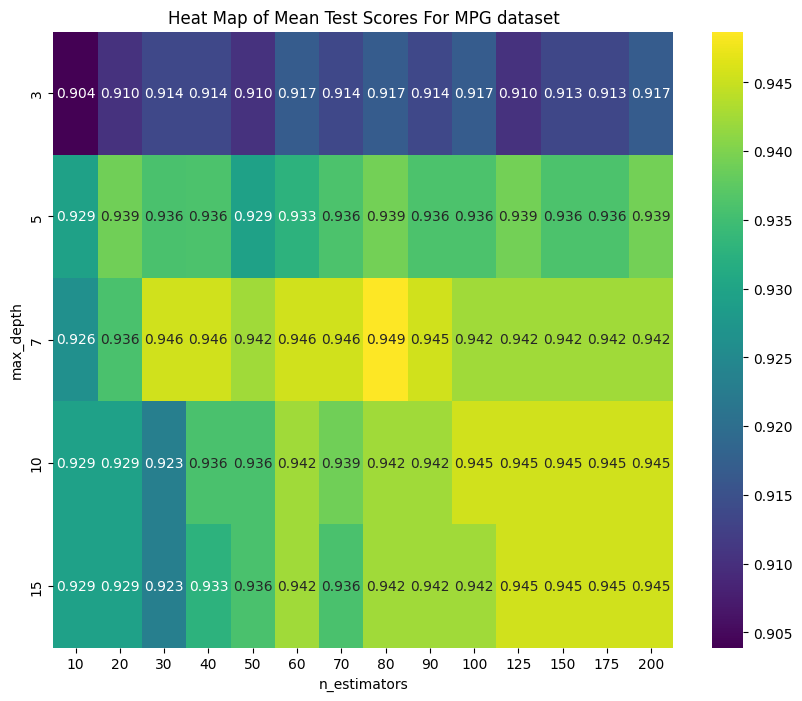

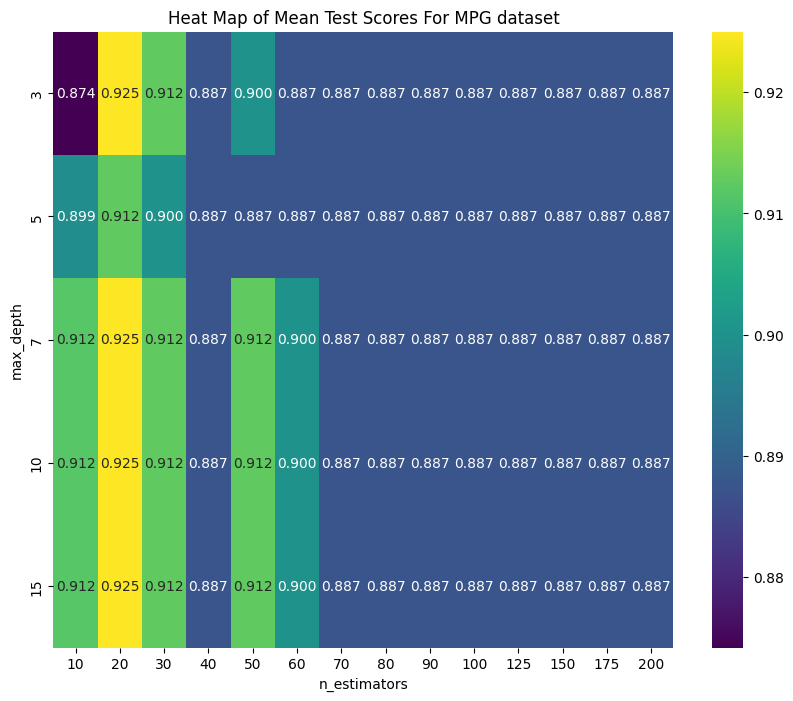

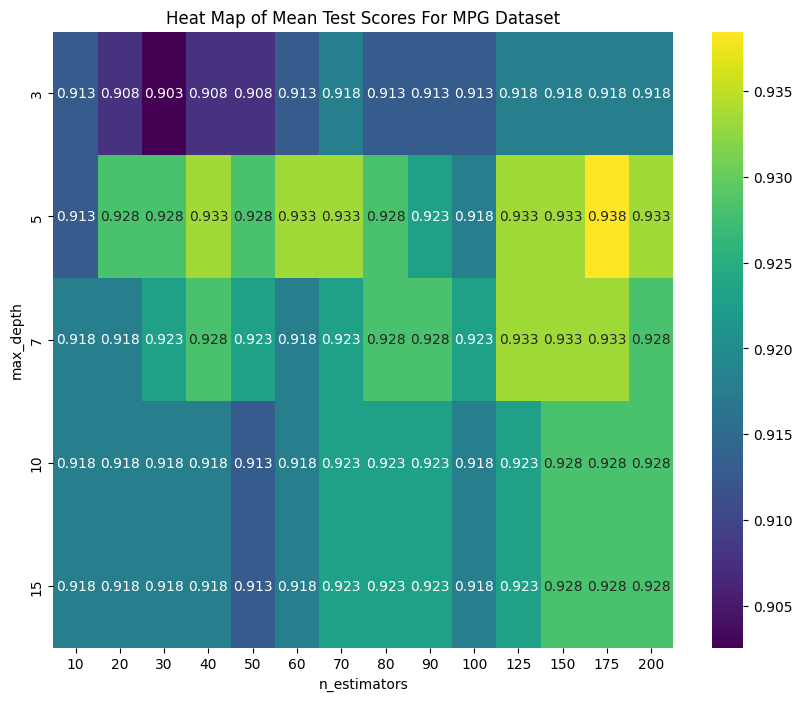

In [33]:
results_80_20 = rf_grid_80_20.cv_results_
# data of interest
results_df_80_20 = pd.DataFrame({ 
    'n_estimators': results_80_20['param_n_estimators'].data,
    'max_depth': results_80_20['param_max_depth'].data,
    'max_features': results_80_20['param_max_features'].data,
    'mean_test_score': results_80_20['mean_test_score'],})
heatmap_data = results_df_80_20.pivot_table(
    values='mean_test_score',
    index='max_depth',
    columns='n_estimators')
#  Plot
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, annot=True, fmt=".3f", cmap="viridis")
plt.title('Heat Map of Mean Test Scores For MPG dataset')
plt.xlabel('n_estimators')
plt.ylabel('max_depth')
plt.show()

results_20_80 = rf_grid_20_80.cv_results_
# data of interest
results_df_20_80 = pd.DataFrame({
    'n_estimators': results_20_80['param_n_estimators'].data,
    'max_depth': results_20_80['param_max_depth'].data,
    'max_features': results_20_80['param_max_features'].data,
    'mean_test_score': results_20_80['mean_test_score'],})
heatmap_data = results_df_20_80.pivot_table(
    values='mean_test_score',
    index='max_depth',
    columns='n_estimators')
#   Plot
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, annot=True, fmt=".3f", cmap="viridis")
plt.title('Heat Map of Mean Test Scores For MPG dataset')
plt.xlabel('n_estimators')
plt.ylabel('max_depth')
plt.show()

results_50_50 = rf_grid_50_50.cv_results_
# data of interest
results_df_50_50 = pd.DataFrame({
    'n_estimators': results_50_50['param_n_estimators'].data,
    'max_depth': results_50_50['param_max_depth'].data,
    'max_features': results_50_50['param_max_features'].data,
    'mean_test_score': results_50_50['mean_test_score'],})
heatmap_data = results_df_50_50.pivot_table(
    values='mean_test_score',
    index='max_depth',
    columns='n_estimators')
#   Plot
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, annot=True, fmt=".3f", cmap="viridis")
plt.title('Heat Map of Mean Test Scores For MPG Dataset')
plt.xlabel('n_estimators')
plt.ylabel('max_depth')
plt.show()

### Accuracy Curve for each MPG Partition

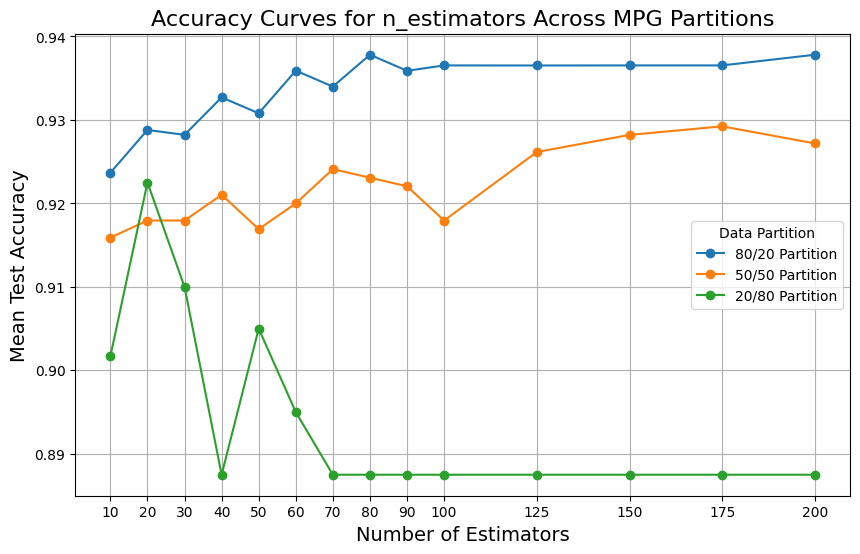

In [34]:
partitions = {
    '80/20': (rf_grid_80_20, XM_test_20, YM_test_20),
    '50/50': (rf_grid_50_50, XM_test_50, YM_test_50),
    '20/80': (rf_grid_20_80, XM_test_80, YM_test_80)}
plt.figure(figsize=(10, 6))
# Loop through each partition
for partition_name, (rf_grid, X_test, Y_test) in partitions.items():
    results_df = pd.DataFrame(rf_grid.cv_results_)
    accuracy_curve_data = results_df.groupby('param_n_estimators')['mean_test_score'].mean()
    # Plot
    plt.plot(
        accuracy_curve_data.index,
        accuracy_curve_data.values,
        marker='o',
        linestyle='-',
        label=f'{partition_name} Partition')
plt.title('Accuracy Curves for n_estimators Across MPG Partitions', fontsize=16)
plt.xlabel('Number of Estimators', fontsize=14)
plt.ylabel('Mean Test Accuracy', fontsize=14)
plt.grid(True)
plt.legend(title='Data Partition')
plt.xticks(accuracy_curve_data.index)  # Ensure x-ticks match n_estimators values
plt.show()